# Phase 1: Data Cleaning & Preprocessing

This notebook performs initial data cleaning and preprocessing on the Used Cars Dataset from Kaggle [ https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data/data ].

**Objectives:**
- Load and inspect the raw dataset
- Drop unnecessary features
- Remove statistical outliers from target variable (price)
- Analyze and handle missing values comprehensively
- Optimize data types
- Export cleaned dataset

## 1. Setup & Configuration

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import os

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seeds for reproducibility
np.random.seed(42)

# Set plot style and color palette
sns.set_style('whitegrid')
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'error': '#C73E1D',
    'success': '#6A994E'
}

In [ ]:
# Check GPU availability
import subprocess

try:
    gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'])
    print("GPU Available:")
    print(gpu_info.decode('utf-8'))
except:
    print("No GPU detected. Running on CPU.")

GPU Available:
NVIDIA L4, 23034 MiB



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define project paths
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction'
DATA_RAW = os.path.join(PROJECT_ROOT, 'data/raw')
DATA_PROCESSED = os.path.join(PROJECT_ROOT, 'data/processed')
RESULTS_FIGURES = os.path.join(PROJECT_ROOT, 'results/figures/eda_plots')

# Create directories if they don't exist
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(RESULTS_FIGURES, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw data path: {DATA_RAW}")
print(f"Processed data path: {DATA_PROCESSED}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction
Raw data path: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction/data/raw
Processed data path: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction/data/processed


## 2. Data Loading & Initial Inspection

In [ ]:
# Load dataset
file_path = os.path.join(DATA_RAW, 'vehicles.csv')
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Shape: (426880, 26)
Memory usage: 4255.72 MB


In [ ]:
# Display first few rows
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [ ]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [ ]:
# Basic statistics for numerical features
df.describe()

,id,price,year,odometer,county,lat,long
count,426880.00,426880.00,425675.00,422480.00,0.00,420331.00,420331.00
mean,7311486634.22,75199.03,2011.24,98043.33,NaN,38.49,-94.75
std,4473170.41,12182282.17,9.45,213881.50,NaN,5.84,18.37
min,7207408119.00,0.00,1900.00,0.00,NaN,-84.12,-159.83
25%,7308143339.25,5900.00,2008.00,37704.00,NaN,34.60,-111.94
50%,7312620821.00,13950.00,2013.00,85548.00,NaN,39.15,-88.43
75%,7315253543.50,26485.75,2017.00,133542.50,NaN,42.40,-80.83
max,7317101084.00,3736928711.00,2022.00,10000000.00,NaN,82.39,173.89


In [ ]:
# Check for duplicate IDs
duplicate_ids = df['id'].duplicated().sum()
print(f"Number of duplicate IDs: {duplicate_ids}")

if duplicate_ids > 0:
    print(f"Removing {duplicate_ids} duplicate entries...")
    df = df.drop_duplicates(subset='id', keep='first')
    print(f"New shape after removing duplicates: {df.shape}")

Number of duplicate IDs: 0


## 3. Feature Dropping

Removing features that are not useful for price prediction.

In [ ]:
# Features to drop
features_to_drop = [
    'url',           # Not useful for prediction
    'region_url',    # Redundant with region
    'image_url',     # Not useful for prediction
    'description',   # Requires NLP, out of scope
    'county',        # Empty column
    'VIN'            # Too high cardinality (118k unique), essentially an ID
]

print("Features to drop:")
for feature in features_to_drop:
    if feature in df.columns:
        print(f"  - {feature}")

# Drop features
df_cleaned = df.drop(columns=features_to_drop, errors='ignore')

print(f"\nShape after dropping features: {df_cleaned.shape}")
print(f"Remaining features: {df_cleaned.shape[1]}")

Features to drop:
  - url
  - region_url
  - image_url
  - description
  - county
  - VIN

Shape after dropping features: (426880, 20)
Remaining features: 20


In [ ]:
# Display remaining columns
print("Remaining features:")
for i, col in enumerate(df_cleaned.columns, 1):
    print(f"{i:2d}. {col} ({df_cleaned[col].dtype})")

Remaining features:
 1. id (int64)
 2. region (object)
 3. price (int64)
 4. year (float64)
 5. manufacturer (object)
 6. model (object)
 7. condition (object)
 8. cylinders (object)
 9. fuel (object)
10. odometer (float64)
11. title_status (object)
12. transmission (object)
13. drive (object)
14. size (object)
15. type (object)
16. paint_color (object)
17. state (object)
18. lat (float64)
19. long (float64)
20. posting_date (object)


## 4. Target Variable Analysis & Outlier Removal

### Plan to Handle Outliers

**Based on the distributions and statistical analysis of numerical features, we used the following methods to handle outliers in the dataset:**\
Applied multi-layered filtering approach to remove extreme outliers while preserving valid data.

**`price`** - Target Variable
- **Remove invalid values:** Zero or negative prices (invalid data entries)
- **Percentile-based filtering:** Remove values below 1st percentile and above 99th percentile (extreme outliers)
- **IQR-based filtering:** Remove values outside Q1 - 1.5×IQR to Q3 + 1.5×IQR (statistical outliers)
- **Rationale:** Price is heavily right-skewed; statistical methods remove unrealistic values while preserving the natural distribution

**`year`** - Vehicle Year
- **Domain-based filter:** Remove years < 1900 or > 2025 (impossible values)
- **Percentile-based filtering:** Remove values below 1st percentile and above 99th percentile (very old vehicles)
- **IQR-based filtering:** Remove values outside Q1 - 1.5×IQR to Q3 + 1.5×IQR (left-tail outliers)
- **Rationale:** Addresses heavy left-skew from vintage vehicles; focuses on recent, relevant used car market

**`odometer`** - Mileage
- **Remove invalid values:** Zero or negative odometer readings (invalid data)
- **Percentile-based filtering:** Remove values below 1st percentile and above 99th percentile (extreme high mileage)
- **IQR-based filtering:** Remove values outside Q1 - 1.5×IQR to Q3 + 1.5×IQR (right-tail outliers)
- **Rationale:** Distribution is extremely right-skewed; removes unrealistic high-mileage values (10M+ miles)

**`lat` / `long`** - Geographic Coordinates
- **Geographic bounds validation:** Latitude between 24.5°N and 49.4°N; Longitude between -125°W and -66°W
- **Rationale:** Ensures all listings are within the continental United States geographic boundaries.

In [ ]:
# Initial price statistics
print("Price Statistics (Before Cleaning):")
print(df_cleaned['price'].describe())
print(f"\nMissing values: {df_cleaned['price'].isna().sum()}")
print(f"Zero or negative prices: {(df_cleaned['price'] <= 0).sum()}")

Price Statistics (Before Cleaning):
count       426880.00
mean         75199.03
std       12182282.17
min              0.00
25%           5900.00
50%          13950.00
75%          26485.75
max     3736928711.00
Name: price, dtype: float64

Missing values: 0
Zero or negative prices: 32895


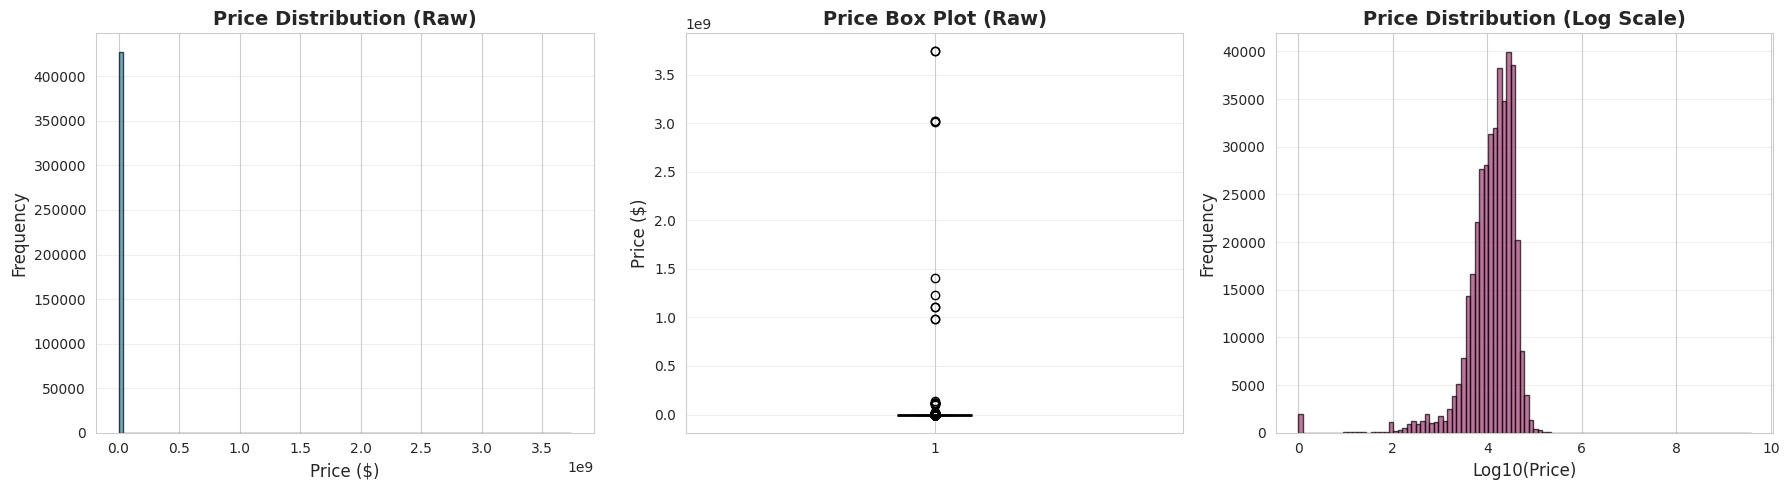

Figure saved: 01_price_distribution_raw.png


In [ ]:
# Visualize price distribution before cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_cleaned['price'].dropna(), bins=100, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution (Raw)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df_cleaned['price'].dropna(), vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title('Price Box Plot (Raw)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Log-scale histogram
price_positive = df_cleaned[df_cleaned['price'] > 0]['price']
axes[2].hist(np.log10(price_positive), bins=100, color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Log10(Price)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Price Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '01_price_distribution_raw.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 01_price_distribution_raw.png")

In [ ]:
zeros_in_price = (df_cleaned['price'] == 0).sum()
print(f"Number of zeros in column 'price': {zeros_in_price}")

over100000_in_price = (df_cleaned['price'] > 100000).sum()
print(f"Number of over 100000 in column 'price': {over100000_in_price}")

under5000_in_price = ((df_cleaned['price'] > 0) & (df_cleaned['price'] <= 5000)).sum()
print(f"Number of under 5000 in column 'price': {under5000_in_price}")

max_price = df_cleaned['price'].max()
print(f"Maximum value in column 'price': {max_price}")

Number of zeros in column 'price': 32895
Number of over 100000 in column 'price': 655
Number of under 5000 in column 'price': 64285
Maximum value in column 'price': 3736928711


In [ ]:
# Remove missing prices
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['price'].notna()]
removed_missing = initial_count - len(df_cleaned)
print(f"Removed {removed_missing} rows with missing prices")

# Remove zero or negative prices (invalid data)
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['price'] > 0]
removed_zero_negative = initial_count - len(df_cleaned)
print(f"Removed {removed_zero_negative} rows with zero or negative prices")
print(f"Remaining rows: {len(df_cleaned)}")

# Statistical outlier removal using IQR method and percentiles
# First, remove extreme outliers (below 1st percentile and above 99th percentile)
p1 = df_cleaned['price'].quantile(0.01)
p99 = df_cleaned['price'].quantile(0.99)

print(f"\n1st percentile: ${p1:,.2f}")
print(f"99th percentile: ${p99:,.2f}")

# Apply percentile-based filtering
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['price'] >= p1) & (df_cleaned['price'] <= p99)]
removed_percentile = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_percentile} rows based on 1st-99th percentile filter")

# Additional IQR-based outlier removal for refined cleaning
Q1 = df_cleaned['price'].quantile(0.25)
Q3 = df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR-based bounds:")
print(f"Lower bound: ${max(0, lower_bound):,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")

initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['price'] >= max(0, lower_bound)) &
                        (df_cleaned['price'] <= upper_bound)]
removed_iqr = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_iqr} additional rows based on IQR method")

print(f"\nTotal rows removed: {removed_missing + removed_percentile + removed_iqr}")
print(f"Remaining rows: {len(df_cleaned)}")
print(f"Percentage retained: {len(df_cleaned) / len(df) * 100:.2f}%")

Removed 0 rows with missing prices
Removed 32895 rows with zero or negative prices
Remaining rows: 393985

1st percentile: $150.00
99th percentile: $68,747.48

Removed 7864 rows based on 1st-99th percentile filter

IQR-based bounds:
Lower bound: $0.00
Upper bound: $56,265.00

Removed 4734 additional rows based on IQR method

Total rows removed: 12598
Remaining rows: 381387
Percentage retained: 89.34%


In [ ]:
# Price statistics after cleaning
print("Price Statistics (After Cleaning):")
print(df_cleaned['price'].describe())
print(f"\nSkewness: {df_cleaned['price'].skew():.3f}")
print(f"Kurtosis: {df_cleaned['price'].kurtosis():.3f}")

Price Statistics (After Cleaning):
count   381387.00
mean     17867.20
std      12631.64
min        150.00
25%       7250.00
50%      14995.00
75%      26990.00
max      56255.00
Name: price, dtype: float64

Skewness: 0.713
Kurtosis: -0.315


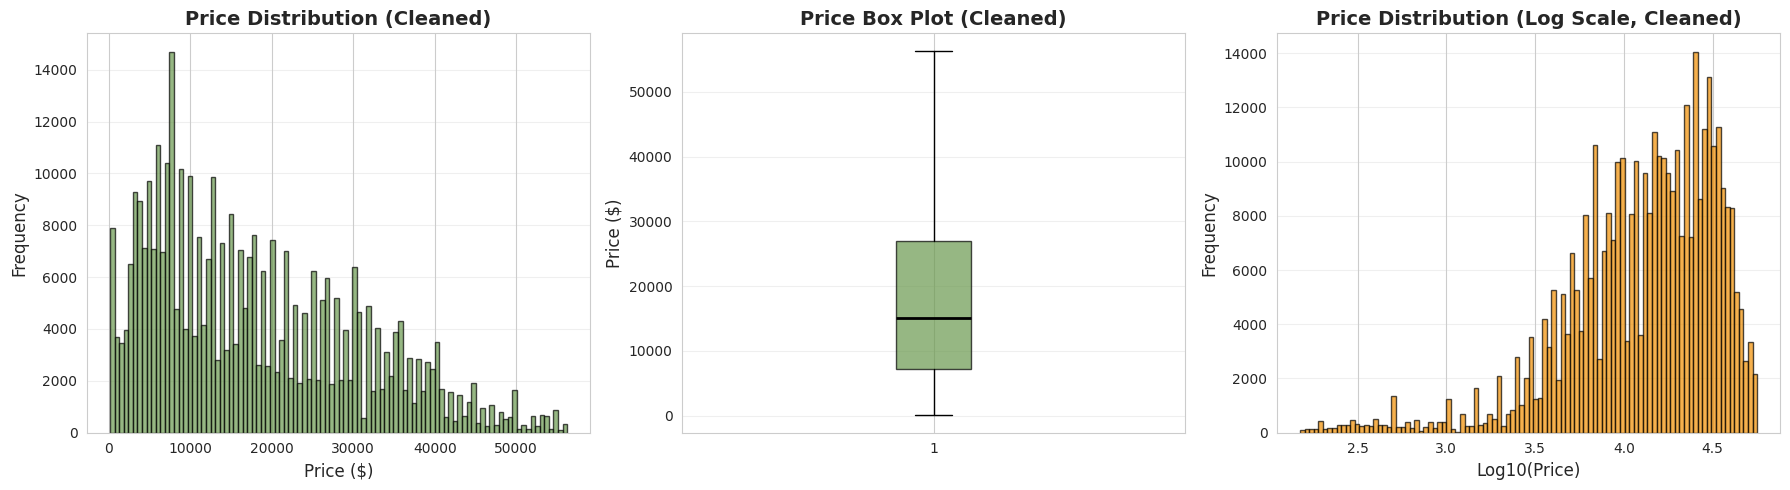

Figure saved: 02_price_distribution_cleaned.png


In [ ]:
# Visualize price distribution after cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df_cleaned['price'], bins=100, color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution (Cleaned)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df_cleaned['price'], vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['success'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title('Price Box Plot (Cleaned)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Log-scale histogram
axes[2].hist(np.log10(df_cleaned['price']), bins=100, color=COLORS['accent'], edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Log10(Price)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Price Distribution (Log Scale, Cleaned)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '02_price_distribution_cleaned.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 02_price_distribution_cleaned.png")

## 5. Cleaning Other Numerical Features

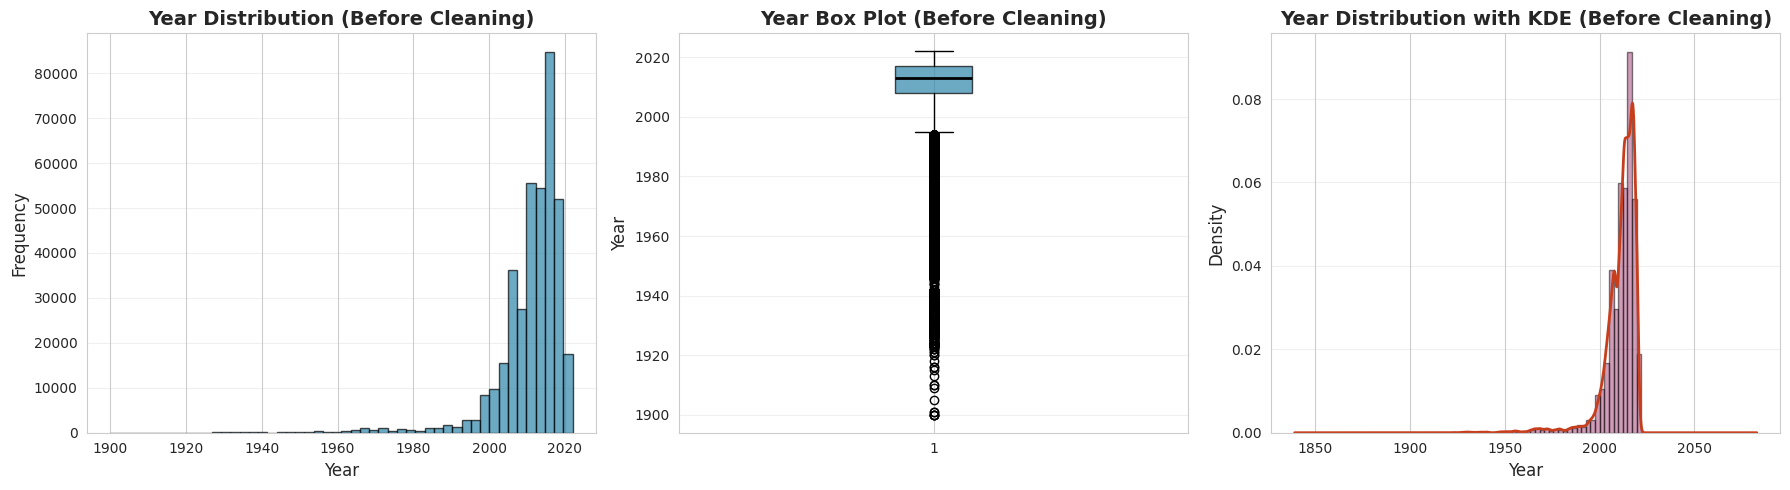

Figure saved: 04_year_distribution_raw.png



In [ ]:
# Visualize year distribution before cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

year_data = df_cleaned['year'].dropna()

# Histogram
axes[0].hist(year_data, bins=50, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Year Distribution (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(year_data, vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Year', fontsize=12)
axes[1].set_title('Year Box Plot (Before Cleaning)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Distribution with KDE
axes[2].hist(year_data, bins=50, color=COLORS['secondary'], edgecolor='black', alpha=0.5, density=True)
year_data.plot.kde(ax=axes[2], color=COLORS['error'], linewidth=2)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Year Distribution with KDE (Before Cleaning)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '04_year_distribution_raw.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 04_year_distribution_raw.png\n")

In [ ]:
# Clean 'year' feature
print("Year Statistics (Before Cleaning):")
print(df_cleaned['year'].describe())
print(f"Missing values: {df_cleaned['year'].isna().sum()}")

# Remove invalid years (before 1900 or after 2025) - domain-based filter
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['year'].isna()) |
                        ((df_cleaned['year'] >= 1900) & (df_cleaned['year'] <= 2025))]
removed_invalid = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_invalid} rows with invalid years (< 1900 or > 2025)")

# Statistical outlier removal using percentile method
p1_year = df_cleaned['year'].quantile(0.01)
p99_year = df_cleaned['year'].quantile(0.99)

print(f"\n1st percentile: {p1_year:.0f}")
print(f"99th percentile: {p99_year:.0f}")

initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['year'].isna()) |
                        ((df_cleaned['year'] >= p1_year) & (df_cleaned['year'] <= p99_year))]
removed_percentile = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_percentile} rows based on 1st-99th percentile filter")

# Additional IQR-based outlier removal
Q1_year = df_cleaned['year'].quantile(0.25)
Q3_year = df_cleaned['year'].quantile(0.75)
IQR_year = Q3_year - Q1_year
lower_bound_year = Q1_year - 1.5 * IQR_year
upper_bound_year = Q3_year + 1.5 * IQR_year

print(f"\nIQR-based bounds:")
print(f"Lower bound: {max(1900, lower_bound_year):.0f}")
print(f"Upper bound: {min(2025, upper_bound_year):.0f}")

initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['year'].isna()) |
                        ((df_cleaned['year'] >= max(1900, lower_bound_year)) &
                         (df_cleaned['year'] <= min(2025, upper_bound_year)))]
removed_iqr = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_iqr} additional rows based on IQR method")

print(f"\nTotal rows removed from year cleaning: {removed_invalid + removed_percentile + removed_iqr}")
print(f"Remaining rows: {len(df_cleaned)}")

Year Statistics (Before Cleaning):
count   380414.00
mean      2010.93
std          9.49
min       1900.00
25%       2008.00
50%       2013.00
75%       2017.00
max       2022.00
Name: year, dtype: float64
Missing values: 973

Removed 0 rows with invalid years (< 1900 or > 2025)

1st percentile: 1967
99th percentile: 2020

Removed 5298 rows based on 1st-99th percentile filter

IQR-based bounds:
Lower bound: 1994
Upper bound: 2025

Removed 11231 additional rows based on IQR method

Total rows removed from year cleaning: 16529
Remaining rows: 364858


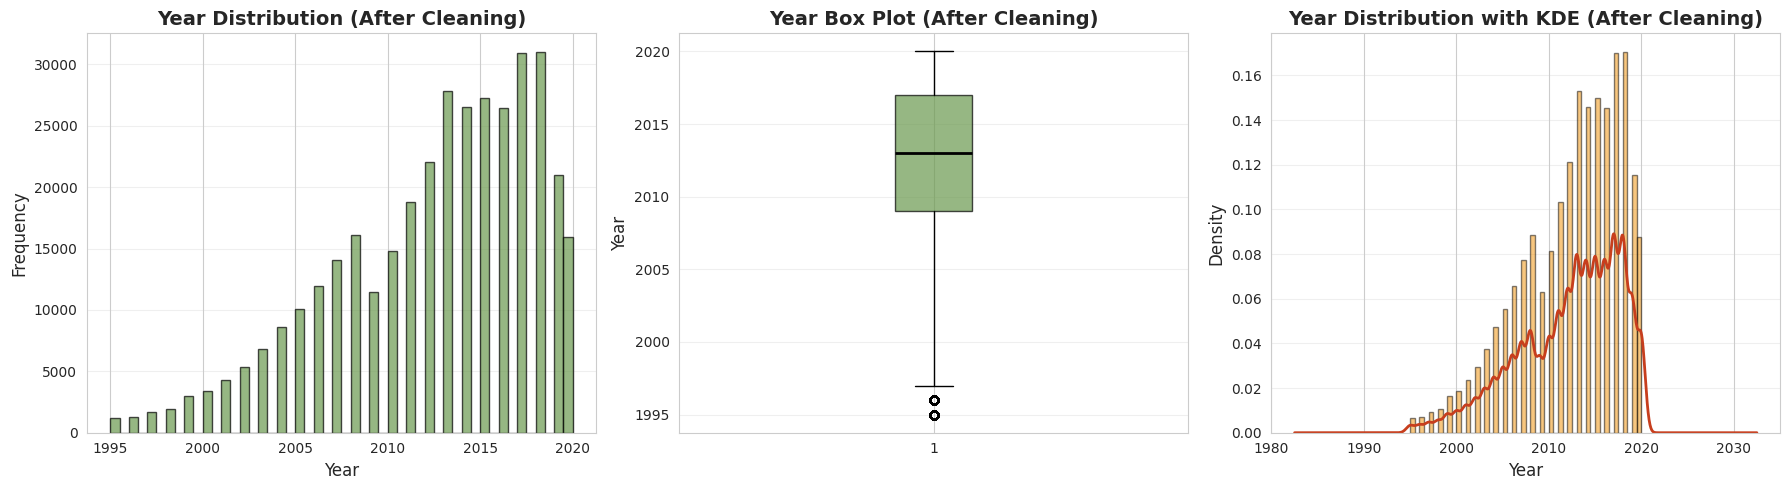

Figure saved: 05_year_distribution_cleaned.png

Skewness: -0.769
Kurtosis: -0.029


In [ ]:
# Visualize year distribution after cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

year_data_cleaned = df_cleaned['year'].dropna()

# Histogram
axes[0].hist(year_data_cleaned, bins=50, color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Year Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(year_data_cleaned, vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['success'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Year', fontsize=12)
axes[1].set_title('Year Box Plot (After Cleaning)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Distribution with KDE
axes[2].hist(year_data_cleaned, bins=50, color=COLORS['accent'], edgecolor='black', alpha=0.5, density=True)
year_data_cleaned.plot.kde(ax=axes[2], color=COLORS['error'], linewidth=2)
axes[2].set_xlabel('Year', fontsize=12)
axes[2].set_ylabel('Density', fontsize=12)
axes[2].set_title('Year Distribution with KDE (After Cleaning)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '05_year_distribution_cleaned.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 05_year_distribution_cleaned.png")

print(f"\nSkewness: {df_cleaned['year'].skew():.3f}")
print(f"Kurtosis: {df_cleaned['year'].kurtosis():.3f}")

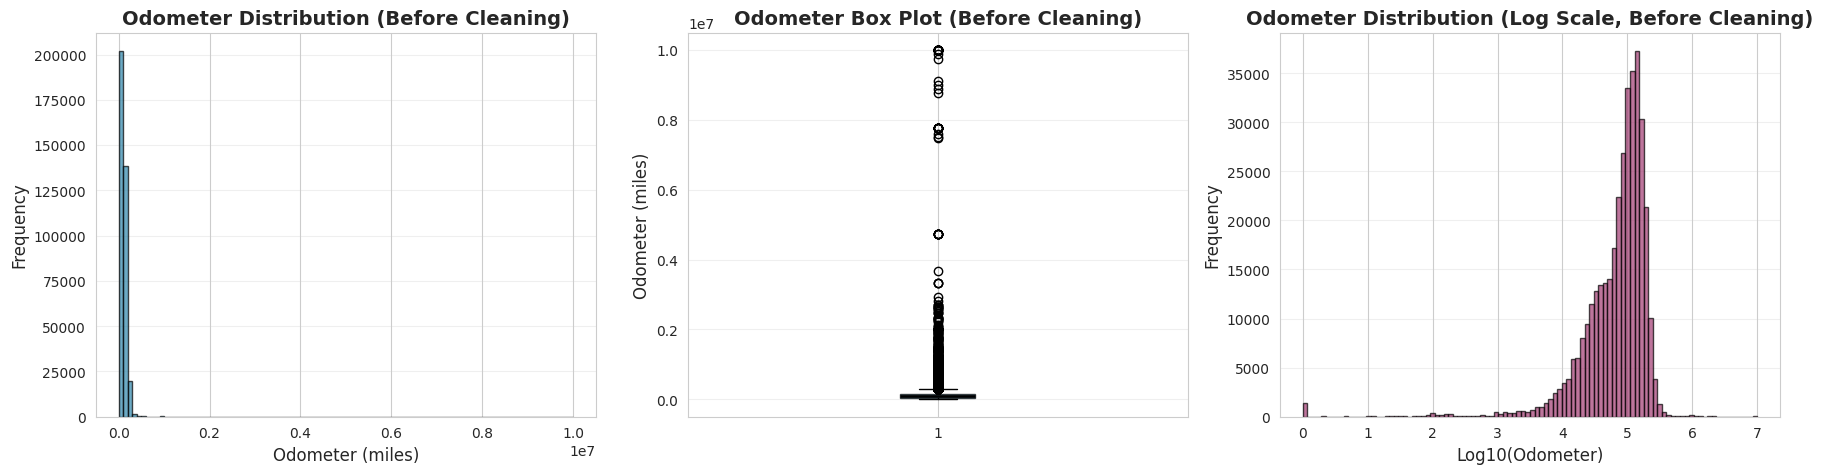

Figure saved: 06_odometer_distribution_raw.png



In [ ]:
# Visualize odometer distribution before cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

odometer_data = df_cleaned['odometer'].dropna()

# Histogram
axes[0].hist(odometer_data, bins=100, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Odometer (miles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Odometer Distribution (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(odometer_data, vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Odometer (miles)', fontsize=12)
axes[1].set_title('Odometer Box Plot (Before Cleaning)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Log-scale histogram
odometer_positive = odometer_data[odometer_data > 0]
axes[2].hist(np.log10(odometer_positive), bins=100, color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Log10(Odometer)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Odometer Distribution (Log Scale, Before Cleaning)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '06_odometer_distribution_raw.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 06_odometer_distribution_raw.png\n")

In [ ]:
zeros_in_odo = (df_cleaned['odometer'] == 0).sum()
print(f"Number of zeros in column 'odometer': {zeros_in_odo}")

negatives_in_odo = (df_cleaned['odometer'] < 0).sum()
print(f"Number of negatives in column 'odometer': {negatives_in_odo}")

null_odo = df_cleaned['odometer'].isnull().sum()
print(f"Null value in column 'odometer': {null_odo}")

Number of zeros in column 'odometer': 728
Number of negatives in column 'odometer': 0
Null value in column 'odometer': 2156


In [ ]:
# Clean 'odometer' feature
print("Odometer Statistics (Before Cleaning):")
print(df_cleaned['odometer'].describe())
print(f"Missing values: {df_cleaned['odometer'].isna().sum()}")
print(f"Zero values: {(df_cleaned['odometer'] == 0).sum()}")
print(f"Negative values: {(df_cleaned['odometer'] < 0).sum()}")

# Remove zero or negative odometer values (invalid data)
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['odometer'].isna()) | (df_cleaned['odometer'] > 0)]
removed_zero_negative = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_zero_negative} rows with zero or negative odometer values")

# Statistical outlier removal using percentile method
p1_odometer = df_cleaned['odometer'].quantile(0.01)
p99_odometer = df_cleaned['odometer'].quantile(0.99)

print(f"\n1st percentile: {p1_odometer:,.0f} miles")
print(f"99th percentile: {p99_odometer:,.0f} miles")

initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['odometer'].isna()) |
                        ((df_cleaned['odometer'] >= p1_odometer) &
                         (df_cleaned['odometer'] <= p99_odometer))]
removed_percentile = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_percentile} rows based on 1st-99th percentile filter")

# Additional IQR-based outlier removal for refined cleaning
Q1_odometer = df_cleaned['odometer'].quantile(0.25)
Q3_odometer = df_cleaned['odometer'].quantile(0.75)
IQR_odometer = Q3_odometer - Q1_odometer
lower_bound_odometer = Q1_odometer - 1.5 * IQR_odometer
upper_bound_odometer = Q3_odometer + 1.5 * IQR_odometer

print(f"\nIQR-based bounds:")
print(f"Lower bound: {max(0, lower_bound_odometer):,.0f} miles")
print(f"Upper bound: {upper_bound_odometer:,.0f} miles")

initial_count = len(df_cleaned)
df_cleaned = df_cleaned[(df_cleaned['odometer'].isna()) |
                        ((df_cleaned['odometer'] >= max(0, lower_bound_odometer)) &
                         (df_cleaned['odometer'] <= upper_bound_odometer))]
removed_iqr = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_iqr} additional rows based on IQR method")

print(f"\nTotal rows removed from odometer cleaning: {removed_zero_negative + removed_percentile + removed_iqr}")
print(f"Remaining rows: {len(df_cleaned)}")

Odometer Statistics (Before Cleaning):
count     362702.00
mean       97785.23
std       139636.63
min            0.00
25%        40260.00
50%        90000.00
75%       137422.00
max     10000000.00
Name: odometer, dtype: float64
Missing values: 2156
Zero values: 728
Negative values: 0

Removed 728 rows with zero or negative odometer values

1st percentile: 220 miles
99th percentile: 273,000 miles

Removed 7209 rows based on 1st-99th percentile filter

IQR-based bounds:
Lower bound: 0 miles
Upper bound: 279,201 miles

Removed 0 additional rows based on IQR method

Total rows removed from odometer cleaning: 7937
Remaining rows: 356921


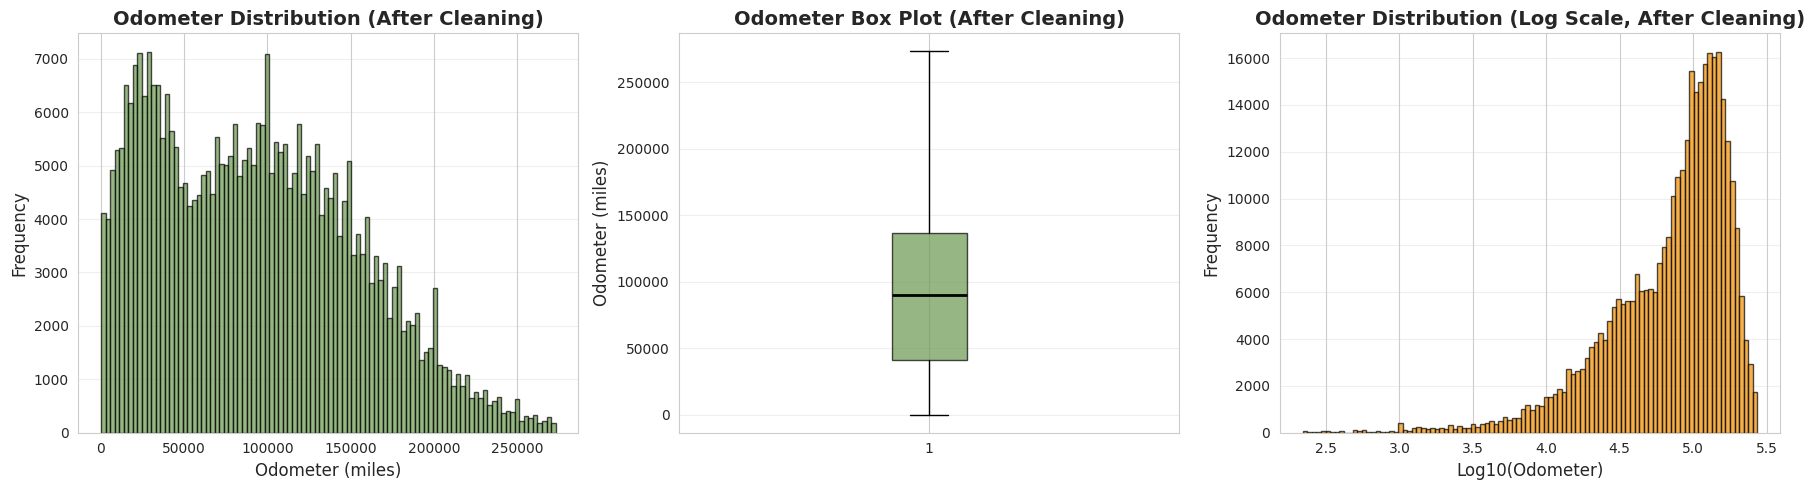

Figure saved: 07_odometer_distribution_cleaned.png


In [ ]:
# Visualize odometer distribution after cleaning
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

odometer_data_cleaned = df_cleaned['odometer'].dropna()

# Histogram
axes[0].hist(odometer_data_cleaned, bins=100, color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Odometer (miles)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Odometer Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(odometer_data_cleaned, vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['success'], alpha=0.7),
                medianprops=dict(color='black', linewidth=2))
axes[1].set_ylabel('Odometer (miles)', fontsize=12)
axes[1].set_title('Odometer Box Plot (After Cleaning)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Log-scale histogram
axes[2].hist(np.log10(odometer_data_cleaned), bins=100, color=COLORS['accent'], edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Log10(Odometer)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Odometer Distribution (Log Scale, After Cleaning)', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '07_odometer_distribution_cleaned.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 07_odometer_distribution_cleaned.png")

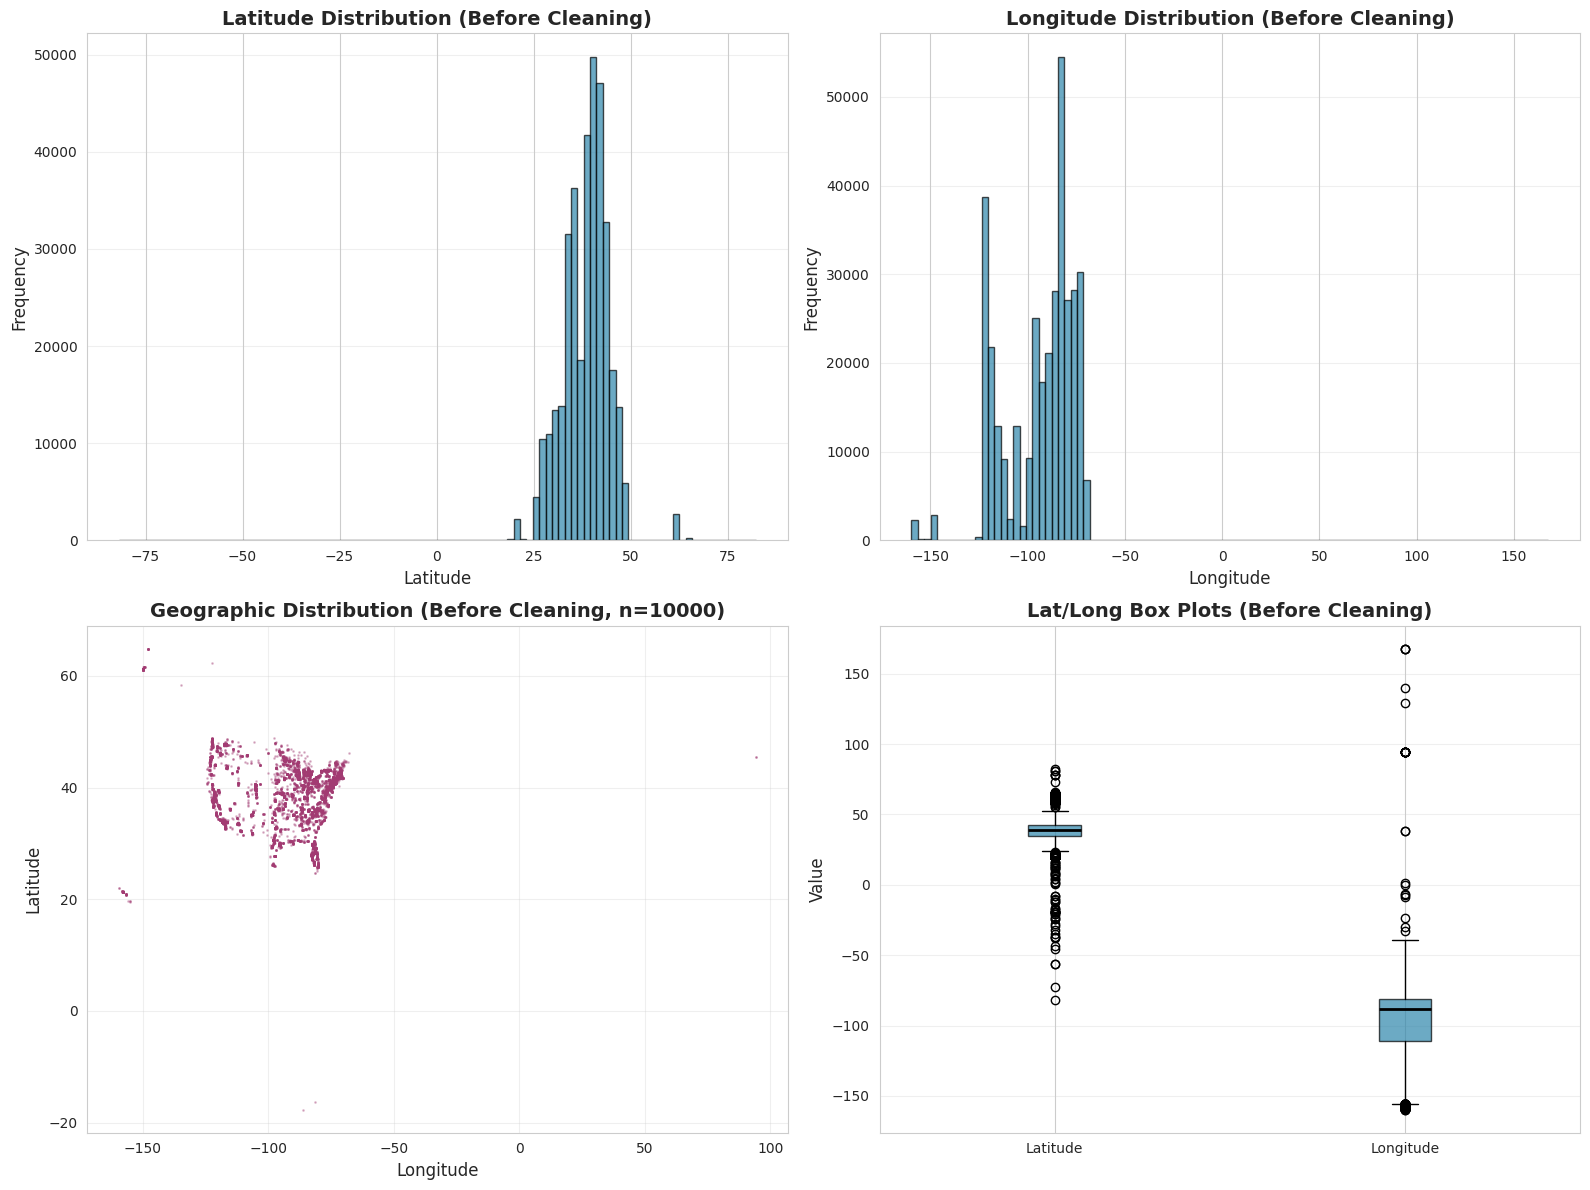

Figure saved: 08_coordinates_distribution_raw.png



In [ ]:
# Visualize geographic coordinates before cleaning
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

lat_data = df_cleaned['lat'].dropna()
long_data = df_cleaned['long'].dropna()

# Latitude histogram
axes[0, 0].hist(lat_data, bins=100, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Latitude', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Latitude Distribution (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Longitude histogram
axes[0, 1].hist(long_data, bins=100, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Longitude', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Longitude Distribution (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Scatter plot of coordinates
# Sample data for performance (max 10000 points)
sample_size = min(10000, len(df_cleaned))
df_sample = df_cleaned.sample(sample_size, random_state=42)
axes[1, 0].scatter(df_sample['long'], df_sample['lat'], alpha=0.3, s=1, color=COLORS['secondary'])
axes[1, 0].set_xlabel('Longitude', fontsize=12)
axes[1, 0].set_ylabel('Latitude', fontsize=12)
axes[1, 0].set_title(f'Geographic Distribution (Before Cleaning, n={sample_size})', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Box plots
box_data = [lat_data, long_data]
bp = axes[1, 1].boxplot(box_data, labels=['Latitude', 'Longitude'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(COLORS['primary'])
    patch.set_alpha(0.7)
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title('Lat/Long Box Plots (Before Cleaning)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '08_coordinates_distribution_raw.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 08_coordinates_distribution_raw.png\n")

In [ ]:
# Clean geographic coordinates (lat, long)
print("Geographic Coordinates Statistics:")
print("\nLatitude:")
print(df_cleaned['lat'].describe())
print(f"Missing values: {df_cleaned['lat'].isna().sum()}")

print("\nLongitude:")
print(df_cleaned['long'].describe())
print(f"Missing values: {df_cleaned['long'].isna().sum()}")

# US geographic bounds (approximately)
# Latitude: 24.5° N (southern tip) to 49.4° N (northern border)
# Longitude: -125° W (west coast) to -66° W (east coast)
initial_count = len(df_cleaned)
df_cleaned = df_cleaned[
    (df_cleaned['lat'].isna()) |
    ((df_cleaned['lat'] >= 24.5) & (df_cleaned['lat'] <= 49.4))
]
df_cleaned = df_cleaned[
    (df_cleaned['long'].isna()) |
    ((df_cleaned['long'] >= -125) & (df_cleaned['long'] <= -66))
]
removed_coords = initial_count - len(df_cleaned)
print(f"\nRemoved {removed_coords} rows with invalid coordinates")
print(f"Remaining rows: {len(df_cleaned)}")

Geographic Coordinates Statistics:

Latitude:
count   353640.00
mean        38.54
std          5.83
min        -81.84
25%         34.78
50%         39.29
75%         42.36
max         82.25
Name: lat, dtype: float64
Missing values: 3281

Longitude:
count   353640.00
mean       -94.15
std         18.11
min       -159.72
25%       -110.66
50%        -87.87
75%        -80.74
max        167.63
Name: long, dtype: float64
Missing values: 3281

Removed 5639 rows with invalid coordinates
Remaining rows: 351282


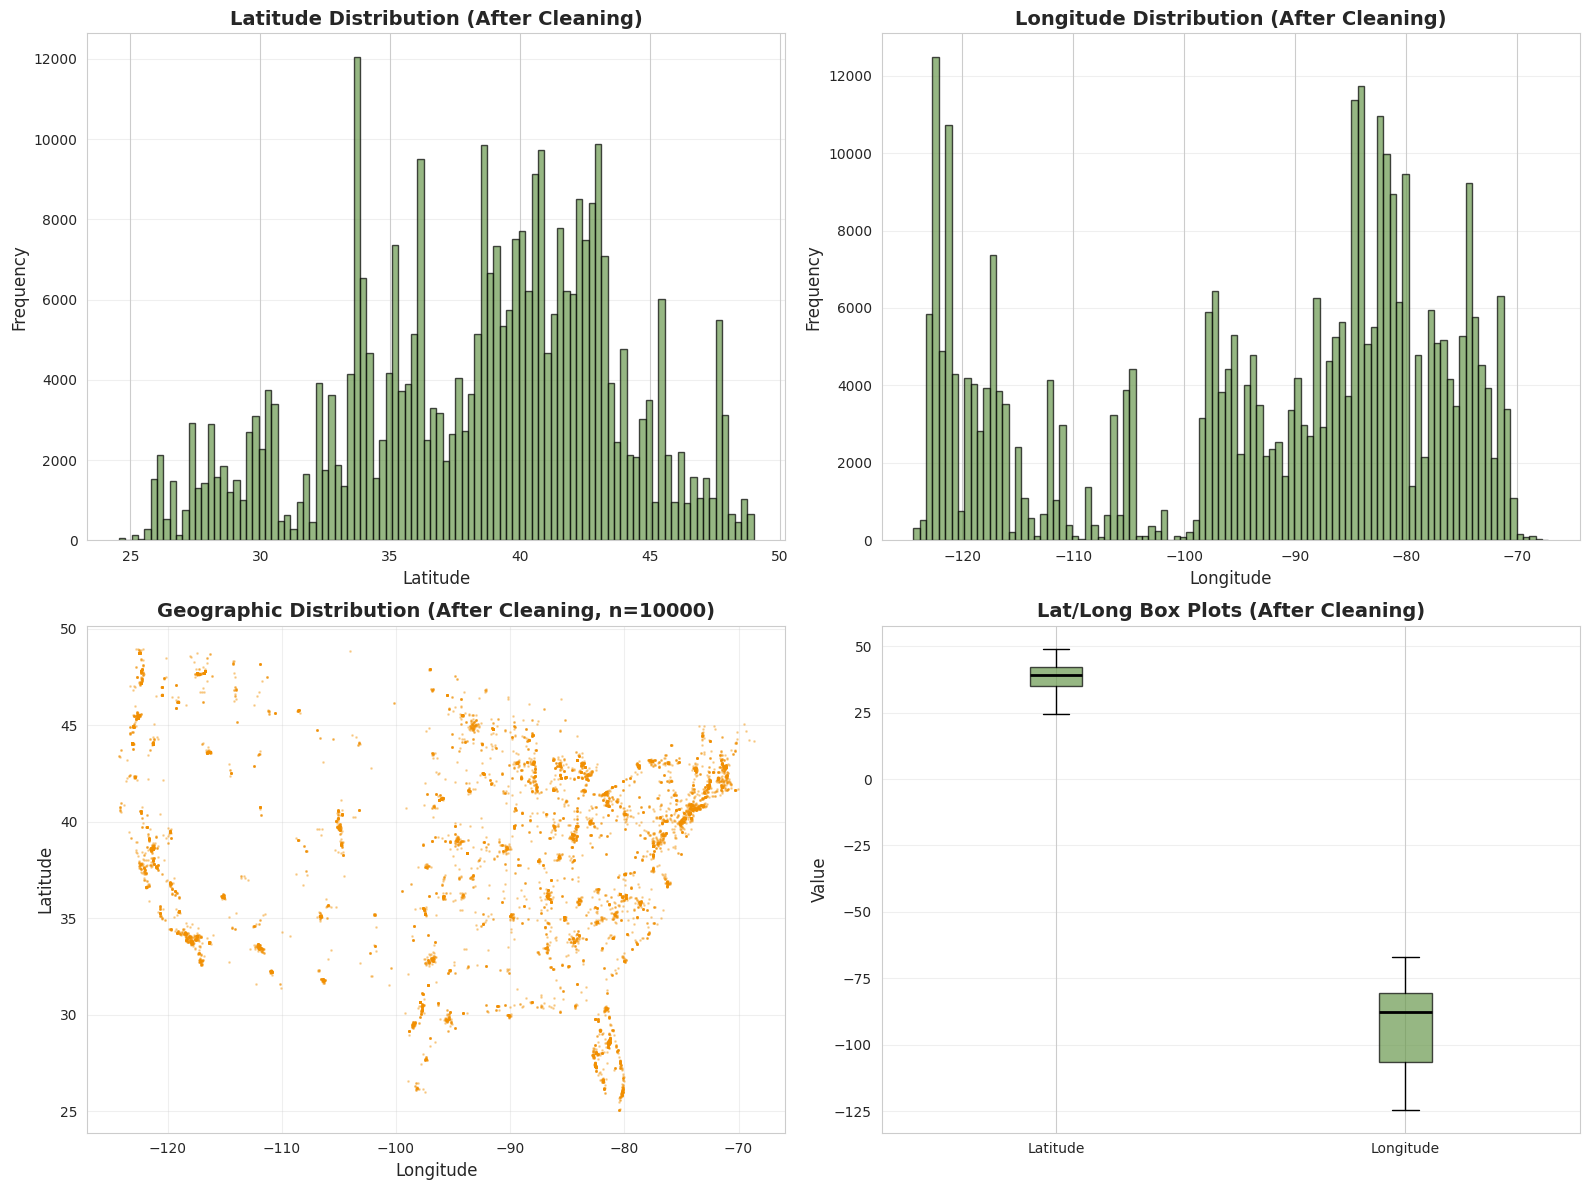

Figure saved: 09_coordinates_distribution_cleaned.png


In [ ]:
# Visualize geographic coordinates after cleaning
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

lat_data_cleaned = df_cleaned['lat'].dropna()
long_data_cleaned = df_cleaned['long'].dropna()

# Latitude histogram
axes[0, 0].hist(lat_data_cleaned, bins=100, color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Latitude', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Latitude Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Longitude histogram
axes[0, 1].hist(long_data_cleaned, bins=100, color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Longitude', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Longitude Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Scatter plot of coordinates
# Sample data for performance (max 10000 points)
sample_size = min(10000, len(df_cleaned))
df_sample_cleaned = df_cleaned.sample(sample_size, random_state=42)
axes[1, 0].scatter(df_sample_cleaned['long'], df_sample_cleaned['lat'], alpha=0.3, s=1, color=COLORS['accent'])
axes[1, 0].set_xlabel('Longitude', fontsize=12)
axes[1, 0].set_ylabel('Latitude', fontsize=12)
axes[1, 0].set_title(f'Geographic Distribution (After Cleaning, n={sample_size})', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Box plots
box_data_cleaned = [lat_data_cleaned, long_data_cleaned]
bp = axes[1, 1].boxplot(box_data_cleaned, labels=['Latitude', 'Longitude'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor(COLORS['success'])
    patch.set_alpha(0.7)
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)
axes[1, 1].set_ylabel('Value', fontsize=12)
axes[1, 1].set_title('Lat/Long Box Plots (After Cleaning)', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '09_coordinates_distribution_cleaned.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 09_coordinates_distribution_cleaned.png")

## 6. Categorical Feature Standardization

In [ ]:
# Analyze categorical features before standardization
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                       'fuel', 'title_status', 'transmission', 'drive', 'size',
                       'type', 'paint_color', 'state']

print("Categorical Features Analysis (Before Standardization):")
print("=" * 80)

cat_summary = []
for feature in categorical_features:
    if feature in df_cleaned.columns:
        n_unique = df_cleaned[feature].nunique()
        n_missing = df_cleaned[feature].isna().sum()
        missing_pct = (n_missing / len(df_cleaned)) * 100

        cat_summary.append({
            'Feature': feature,
            'Unique_Values': n_unique,
            'Missing_Count': n_missing,
            'Missing_Pct': missing_pct
        })

cat_summary_df = pd.DataFrame(cat_summary)
print(cat_summary_df.to_string(index=False))
print("=" * 80)

Categorical Features Analysis (Before Standardization):
     Feature  Unique_Values  Missing_Count  Missing_Pct
      region            403              0         0.00
manufacturer             41          11058         3.15
       model          22637           2829         0.81
   condition              6         131947        37.56
   cylinders              8         143633        40.89
        fuel              5           2281         0.65
title_status              6           6862         1.95
transmission              3           1583         0.45
       drive              3         106283        30.26
        size              4         254111        72.34
        type             13          71854        20.45
 paint_color             12         101697        28.95
       state             51              0         0.00


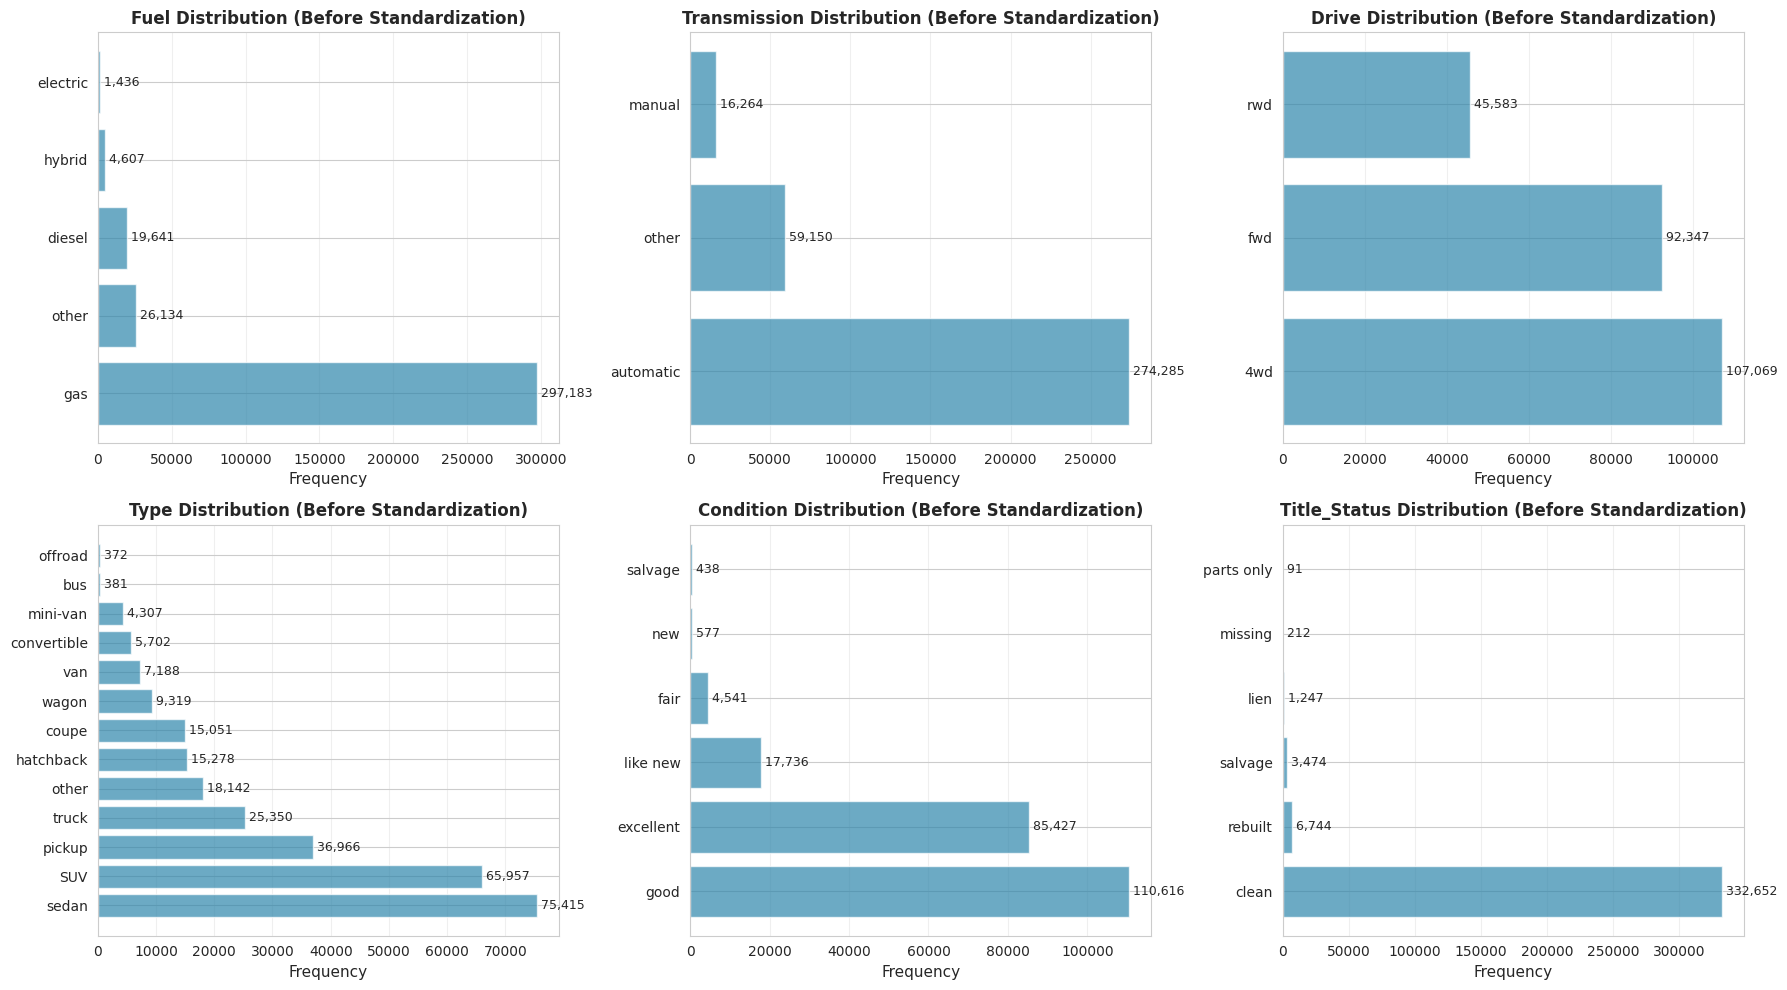

Figure saved: 10_categorical_features_before_standardization.png


In [ ]:
# Visualize low-cardinality categorical features (before standardization)
low_cardinality_features = ['fuel', 'transmission', 'drive', 'type', 'condition', 'title_status']
low_cardinality_features = [f for f in low_cardinality_features if f in df_cleaned.columns]

n_features = len(low_cardinality_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(low_cardinality_features):
    value_counts = df_cleaned[feature].value_counts().head(15)

    axes[idx].barh(range(len(value_counts)), value_counts.values, color=COLORS['primary'], alpha=0.7)
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index, fontsize=10)
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{feature.title()} Distribution (Before Standardization)',
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(value_counts.values):
        axes[idx].text(v, i, f' {v:,}', va='center', fontsize=9)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '10_categorical_features_before_standardization.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 10_categorical_features_before_standardization.png")

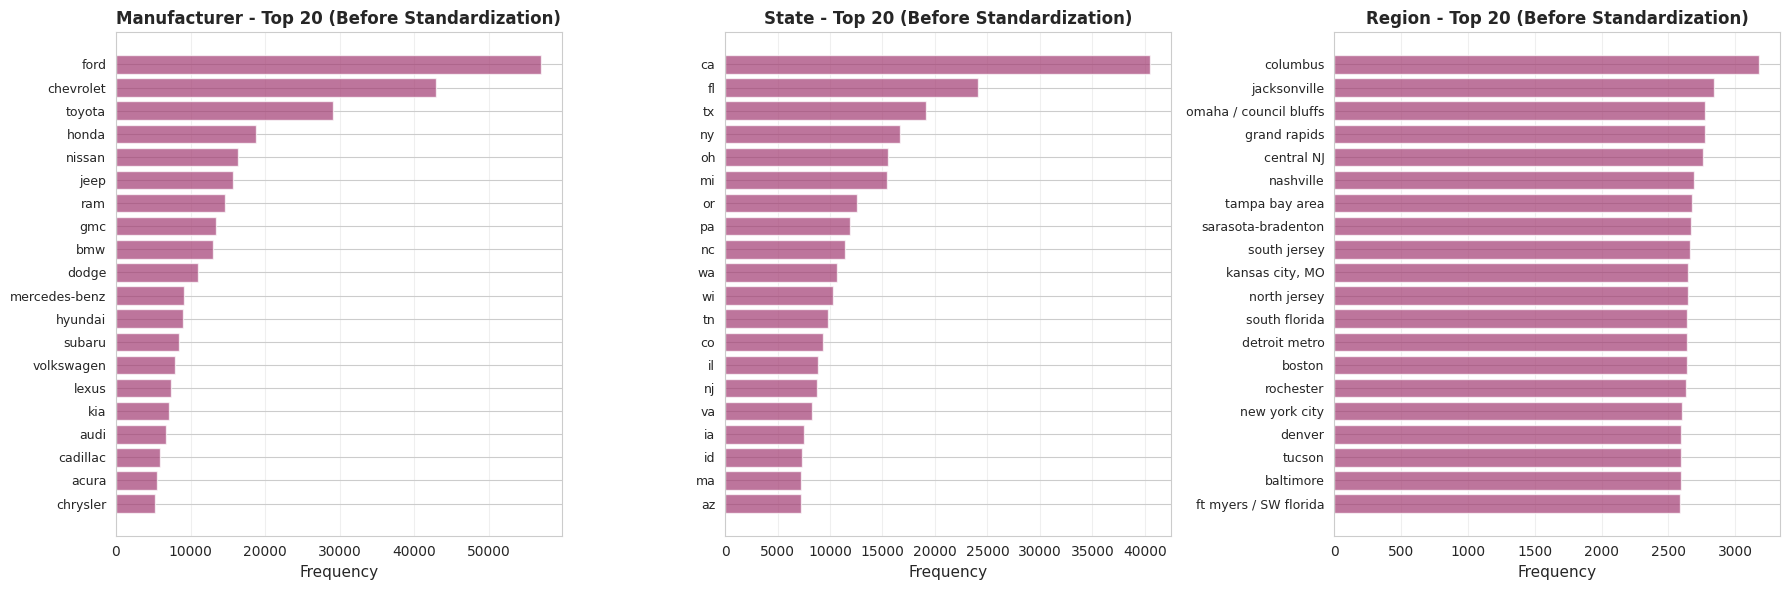

Figure saved: 11_high_cardinality_features_before_standardization.png


In [ ]:
# Visualize high-cardinality categorical features (top values only)
high_cardinality_features = ['manufacturer', 'state', 'region']
high_cardinality_features = [f for f in high_cardinality_features if f in df_cleaned.columns]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, feature in enumerate(high_cardinality_features):
    value_counts = df_cleaned[feature].value_counts().head(20)

    axes[idx].barh(range(len(value_counts)), value_counts.values, color=COLORS['secondary'], alpha=0.7)
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index, fontsize=9)
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{feature.title()} - Top 20 (Before Standardization)',
                        fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '11_high_cardinality_features_before_standardization.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 11_high_cardinality_features_before_standardization.png")

In [ ]:
# Standardize categorical features (lowercase, strip whitespace)
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                       'fuel', 'title_status', 'transmission', 'drive', 'size',
                       'type', 'paint_color', 'state']

for feature in categorical_features:
    if feature in df_cleaned.columns:
        # Convert to string, lowercase, and strip whitespace
        df_cleaned[feature] = df_cleaned[feature].astype(str).str.lower().str.strip()
        # Replace 'nan' string back to actual NaN
        df_cleaned[feature] = df_cleaned[feature].replace('nan', np.nan)

print("Categorical features standardized successfully!")

Categorical features standardized successfully!


In [ ]:
# Verify standardization by checking unique values after cleaning
print("\nCategorical Features After Standardization:")
print("=" * 80)

cat_summary_after = []
for feature in categorical_features:
    if feature in df_cleaned.columns:
        n_unique = df_cleaned[feature].nunique()
        n_missing = df_cleaned[feature].isna().sum()
        missing_pct = (n_missing / len(df_cleaned)) * 100

        cat_summary_after.append({
            'Feature': feature,
            'Unique_Values': n_unique,
            'Missing_Count': n_missing,
            'Missing_Pct': missing_pct
        })

cat_summary_after_df = pd.DataFrame(cat_summary_after)
print(cat_summary_after_df.to_string(index=False))
print("=" * 80)


Categorical Features After Standardization:
     Feature  Unique_Values  Missing_Count  Missing_Pct
      region            403              0         0.00
manufacturer             41          11058         3.15
       model          21970           2829         0.81
   condition              6         131947        37.56
   cylinders              8         143633        40.89
        fuel              5           2281         0.65
title_status              6           6862         1.95
transmission              3           1583         0.45
       drive              3         106283        30.26
        size              4         254111        72.34
        type             13          71854        20.45
 paint_color             12         101697        28.95
       state             51              0         0.00


## 7. Missing Value Analysis

Comprehensive analysis of missing values across all features.

In [ ]:
# Calculate missing value statistics
missing_stats = pd.DataFrame({
    'Feature': df_cleaned.columns,
    'Missing_Count': df_cleaned.isna().sum().values,
    'Missing_Percentage': (df_cleaned.isna().sum().values / len(df_cleaned) * 100)
})

# Sort by missing percentage
missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)
missing_stats = missing_stats[missing_stats['Missing_Percentage'] > 0]

print("Missing Value Analysis:")
print("=" * 60)
print(missing_stats.to_string(index=False))
print("=" * 60)

Missing Value Analysis:
     Feature  Missing_Count  Missing_Percentage
        size         254111               72.34
   cylinders         143633               40.89
   condition         131947               37.56
       drive         106283               30.26
 paint_color         101697               28.95
        type          71854               20.45
manufacturer          11058                3.15
title_status           6862                1.95
         lat           3281                0.93
        long           3281                0.93
       model           2829                0.81
        fuel           2281                0.65
    odometer           2139                0.61
transmission           1583                0.45
        year            854                0.24
posting_date             62                0.02


In [ ]:
# Categorize features by missing value severity
low_missing = missing_stats[missing_stats['Missing_Percentage'] < 5]['Feature'].tolist()
medium_missing = missing_stats[(missing_stats['Missing_Percentage'] >= 5) &
                               (missing_stats['Missing_Percentage'] <= 30)]['Feature'].tolist()
high_missing = missing_stats[missing_stats['Missing_Percentage'] > 30]['Feature'].tolist()

print(f"\nLow Missing (<5%): {len(low_missing)} features")
print(low_missing)

print(f"\nMedium Missing (5-30%): {len(medium_missing)} features")
print(medium_missing)

print(f"\nHigh Missing (>30%): {len(high_missing)} features")
print(high_missing)


Low Missing (<5%): 10 features
['manufacturer', 'title_status', 'lat', 'long', 'model', 'fuel', 'odometer', 'transmission', 'year', 'posting_date']

Medium Missing (5-30%): 2 features
['paint_color', 'type']

High Missing (>30%): 4 features
['size', 'cylinders', 'condition', 'drive']


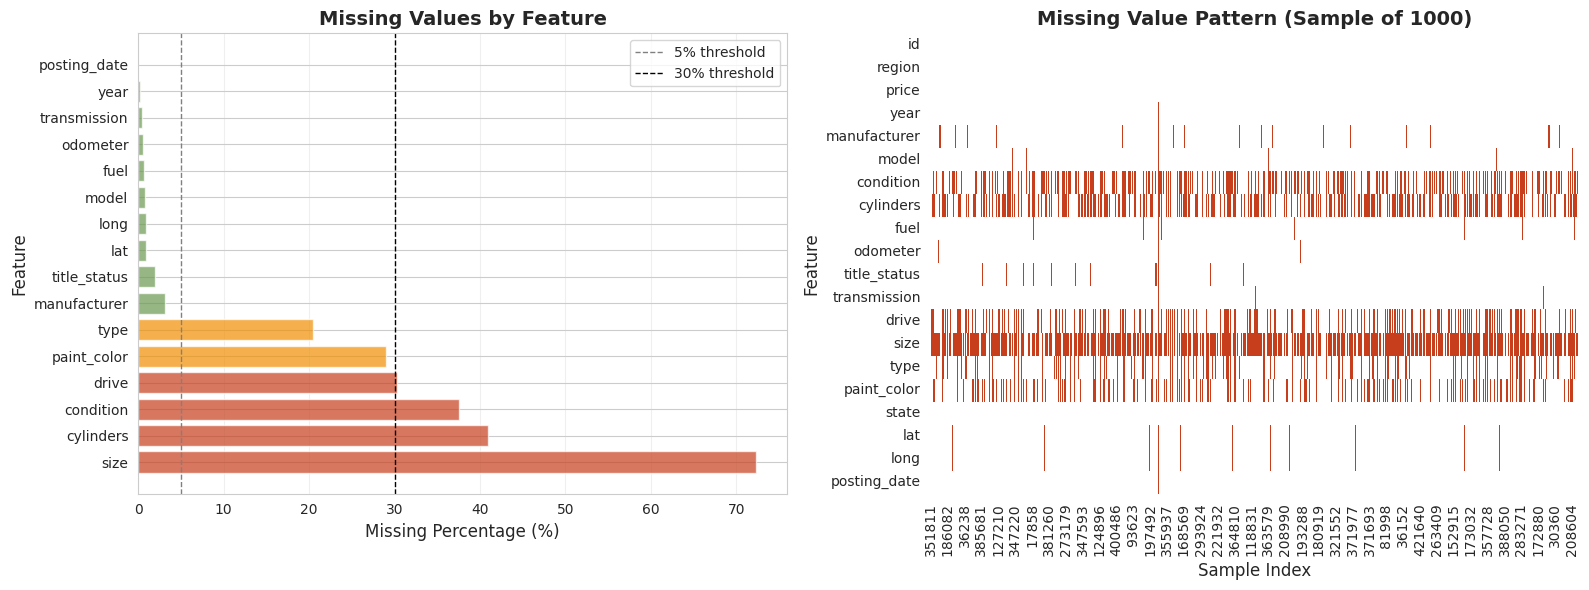

Figure saved: 03_missing_values_analysis.png


In [ ]:
# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of missing percentages
if len(missing_stats) > 0:
    colors = [COLORS['success'] if x < 5 else COLORS['accent'] if x <= 30 else COLORS['error']
              for x in missing_stats['Missing_Percentage']]

    axes[0].barh(missing_stats['Feature'], missing_stats['Missing_Percentage'], color=colors, alpha=0.7)
    axes[0].set_xlabel('Missing Percentage (%)', fontsize=12)
    axes[0].set_ylabel('Feature', fontsize=12)
    axes[0].set_title('Missing Values by Feature', fontsize=14, fontweight='bold')
    axes[0].axvline(x=5, color='gray', linestyle='--', linewidth=1, label='5% threshold')
    axes[0].axvline(x=30, color='black', linestyle='--', linewidth=1, label='30% threshold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)

    # Missing value heatmap (sample of data)
    sample_size = min(1000, len(df_cleaned))
    missing_mask = df_cleaned.sample(sample_size, random_state=42).isna()
    sns.heatmap(missing_mask.T, cmap=['white', COLORS['error']], cbar=False, ax=axes[1])
    axes[1].set_xlabel('Sample Index', fontsize=12)
    axes[1].set_ylabel('Feature', fontsize=12)
    axes[1].set_title(f'Missing Value Pattern (Sample of {sample_size})', fontsize=14, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'No missing values found', ha='center', va='center', fontsize=14)
    axes[0].axis('off')
    axes[1].text(0.5, 0.5, 'No missing values found', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, '03_missing_values_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: 03_missing_values_analysis.png")

In [ ]:
# Analyze unique values for categorical features
print("\nCategorical Feature Cardinality:")
print("=" * 60)
for feature in categorical_features:
    if feature in df_cleaned.columns:
        n_unique = df_cleaned[feature].nunique()
        missing_pct = df_cleaned[feature].isna().sum() / len(df_cleaned) * 100
        print(f"{feature:20s}: {n_unique:6d} unique values ({missing_pct:5.2f}% missing)")
print("=" * 60)


Categorical Feature Cardinality:
region              :    403 unique values ( 0.00% missing)
manufacturer        :     41 unique values ( 3.15% missing)
model               :  21970 unique values ( 0.81% missing)
condition           :      6 unique values (37.56% missing)
cylinders           :      8 unique values (40.89% missing)
fuel                :      5 unique values ( 0.65% missing)
title_status        :      6 unique values ( 1.95% missing)
transmission        :      3 unique values ( 0.45% missing)
drive               :      3 unique values (30.26% missing)
size                :      4 unique values (72.34% missing)
type                :     13 unique values (20.45% missing)
paint_color         :     12 unique values (28.95% missing)
state               :     51 unique values ( 0.00% missing)


## 8. Missing Value Handling
### Plan to handle missing values in the dataset:
Based on the percentages of missing values in each of the features, we will use the following methods to handle the missing values in the dataset:
- **DROP features**
    - `size` - over 70% of the data is missing in this feature and imputing values would not provide any useful information while introducing heavy bias.
- **REPLACE missing values** with `"unknown"` label to reatain information.\
This allows us to retain data to understand how missing information in a vehicle's listing page affects its value.
    - `cylinders`
    - `condition`
    - `drive`
    - `paint_color`
    - `type`
    - `manufacturer`
    - `title_status`
    - `model`
    - `fuel`
    - `transmission`
- **IMPUTE missing values**
    - `odometer` - impute with **median** by Manufacturer+Year
    - `year` - impute with **mode** by Manufacturer+Model
- **DROP records with missing values**
    - `lat`
    - `long`
    - `posting_date`

### 8.1 Drop Features with High Missing Values

In [ ]:
# Store initial shape for tracking
initial_rows = len(df_cleaned)
initial_cols = len(df_cleaned.columns)
print(f"Initial dataset shape: {df_cleaned.shape}")

# Drop 'size' feature (high missing percentage and low predictive value)
features_to_drop = ['size']

print("Dropping features with high missing values:")
for feature in features_to_drop:
    if feature in df_cleaned.columns:
        missing_pct = (df_cleaned[feature].isna().sum() / len(df_cleaned)) * 100
        print(f"  - {feature}: {missing_pct:.2f}% missing")
        df_cleaned = df_cleaned.drop(columns=[feature])

print(f"\nShape after dropping features: {df_cleaned.shape}")

Initial dataset shape: (351282, 20)
Dropping features with high missing values:
  - size: 72.34% missing

Shape after dropping features: (351282, 19)


### 8.2 Replace Missing Values with `'unknown'` for Categorical Features

In [ ]:
# Replace missing values with 'unknown' for specified categorical features
features_to_replace_unknown = [
    'cylinders', 'condition', 'drive', 'paint_color', 'type',
    'manufacturer', 'title_status', 'model', 'fuel', 'transmission'
]

print("Replacing missing values with 'unknown':\n")
for feature in features_to_replace_unknown:
    if feature in df_cleaned.columns:
        missing_before = df_cleaned[feature].isna().sum()
        df_cleaned[feature] = df_cleaned[feature].fillna('unknown')
        missing_after = df_cleaned[feature].isna().sum()
        print(f"{feature:20s}: {missing_before:8,} → {missing_after:8,} missing values")


Replacing missing values with 'unknown':

cylinders           :  143,633 →        0 missing values
condition           :  131,947 →        0 missing values
drive               :  106,283 →        0 missing values
paint_color         :  101,697 →        0 missing values
type                :   71,854 →        0 missing values
manufacturer        :   11,058 →        0 missing values
title_status        :    6,862 →        0 missing values
model               :    2,829 →        0 missing values
fuel                :    2,281 →        0 missing values
transmission        :    1,583 →        0 missing values


### 8.3 Median Imputation for Odometer (by Manufacturer + Year)

In [ ]:
# Impute odometer with median grouped by Manufacturer and Year
print("Imputing odometer with median by Manufacturer + Year:\n")

if 'odometer' in df_cleaned.columns:
    missing_before = df_cleaned['odometer'].isna().sum()
    print(f"Missing odometer values before imputation: {missing_before:,}")

    # Calculate median odometer by manufacturer and year
    median_by_group = df_cleaned.groupby(['manufacturer', 'year'])['odometer'].median()

    # Fill missing values using group medians
    def fill_odometer(row):
        if pd.isna(row['odometer']):
            try:
                return median_by_group.loc[(row['manufacturer'], row['year'])]
            except KeyError:
                # If group doesn't exist, use overall median
                return df_cleaned['odometer'].median()
        return row['odometer']

    df_cleaned['odometer'] = df_cleaned.apply(fill_odometer, axis=1)

    missing_after = df_cleaned['odometer'].isna().sum()
    print(f"Missing odometer values after imputation: {missing_after:,}")
    print(f"Values imputed: {missing_before - missing_after:,}")

Imputing odometer with median by Manufacturer + Year:

Missing odometer values before imputation: 2,139
Missing odometer values after imputation: 0
Values imputed: 2,139


### 8.4 Mode Imputation for Year (by Manufacturer + Model)

In [ ]:
# Impute year with mode grouped by Manufacturer and Model
print("Imputing year with mode by Manufacturer + Model:\n")

if 'year' in df_cleaned.columns:
    missing_before = df_cleaned['year'].isna().sum()
    print(f"Missing year values before imputation: {missing_before:,}")

    # Calculate mode (most common year) by manufacturer and model
    def get_group_mode(group):
        mode_val = group.mode()
        return mode_val.iloc[0] if len(mode_val) > 0 else None

    mode_by_group = df_cleaned.groupby(['manufacturer', 'model'])['year'].apply(get_group_mode)

    # Fill missing values using group modes
    def fill_year(row):
        if pd.isna(row['year']):
            try:
                mode_val = mode_by_group.loc[(row['manufacturer'], row['model'])]
                if pd.notna(mode_val):
                    return mode_val
                else:
                    # If group mode is null, use overall mode
                    return df_cleaned['year'].mode()[0]
            except KeyError:
                # If group doesn't exist, use overall mode
                return df_cleaned['year'].mode()[0]
        return row['year']

    df_cleaned['year'] = df_cleaned.apply(fill_year, axis=1)

    missing_after = df_cleaned['year'].isna().sum()
    print(f"Missing year values after imputation: {missing_after:,}")
    print(f"Values imputed: {missing_before - missing_after:,}")

Imputing year with mode by Manufacturer + Model:

Missing year values before imputation: 854
Missing year values after imputation: 0
Values imputed: 854


### 8.5 Drop Records with Missing Geographic/Temporal Data

In [ ]:
# Drop records with missing lat, long, or posting_date
print("Dropping records with missing geographic or temporal data:")
print("=" * 80)

features_to_drop_records = ['lat', 'long', 'posting_date']
total_dropped = 0

for feature in features_to_drop_records:
    if feature in df_cleaned.columns:
        initial_count = len(df_cleaned)

        # Check for different types of missing values
        nan_count = df_cleaned[feature].isna().sum()

        # For string columns, also check for string "NaN" or "nan"
        if df_cleaned[feature].dtype == 'object':
            string_nan_count = (df_cleaned[feature] == 'NaN').sum()
            string_nan_lower = (df_cleaned[feature] == 'nan').sum()
            empty_string_count = (df_cleaned[feature] == '').sum()

            print(f"\n{feature.upper()} - Missing value breakdown:")
            print(f"  Actual NaN/None: {nan_count:,}")
            print(f"  String 'NaN': {string_nan_count:,}")
            print(f"  String 'nan': {string_nan_lower:,}")
            print(f"  Empty strings: {empty_string_count:,}")

            # Replace string representations with actual NaN
            df_cleaned[feature] = df_cleaned[feature].replace(['NaN', 'nan', '', ' '], pd.NA)

        # Now count total missing after replacements
        missing_count = df_cleaned[feature].isna().sum()

        # Drop records with missing values
        df_cleaned = df_cleaned[df_cleaned[feature].notna()].copy()

        dropped = initial_count - len(df_cleaned)
        total_dropped += dropped

        print(f"\n{feature:20s}: Dropped {dropped:,} records")
        print(f"{'':20s}  Remaining: {len(df_cleaned):,}")

print("\n" + "=" * 80)
print(f"TOTAL RECORDS DROPPED: {total_dropped:,}")
print(f"REMAINING RECORDS: {len(df_cleaned):,}")
print("=" * 80)

# CRITICAL VERIFICATION STEP
print("\nVERIFYING DATA INTEGRITY:")
print("-" * 80)
for feature in features_to_drop_records:
    if feature in df_cleaned.columns:
        remaining_missing = df_cleaned[feature].isna().sum()

        # Additional checks for object dtypes
        if df_cleaned[feature].dtype == 'object':
            remaining_string_nan = (df_cleaned[feature] == 'NaN').sum()
            remaining_string_nan_lower = (df_cleaned[feature] == 'nan').sum()
            remaining_empty = (df_cleaned[feature] == '').sum()

            print(f"{feature}:")
            print(f"  Missing (NaN): {remaining_missing}")
            print(f"  String 'NaN': {remaining_string_nan}")
            print(f"  String 'nan': {remaining_string_nan_lower}")
            print(f"  Empty strings: {remaining_empty}")

            if remaining_missing > 0 or remaining_string_nan > 0 or remaining_string_nan_lower > 0:
                print(f"  ⚠️  WARNING: {feature} still has missing values!")
            else:
                print(f"  ✓ {feature} is clean!")
        else:
            print(f"{feature}: {remaining_missing} missing values")
            if remaining_missing > 0:
                print(f"  ⚠️  WARNING: {feature} still has missing values!")
            else:
                print(f"  ✓ {feature} is clean!")

print("-" * 80)

Dropping records with missing geographic or temporal data:

lat                 : Dropped 3,281 records
                      Remaining: 348,001

long                : Dropped 0 records
                      Remaining: 348,001

POSTING_DATE - Missing value breakdown:
  Actual NaN/None: 0
  String 'NaN': 0
  String 'nan': 0
  Empty strings: 0

posting_date        : Dropped 0 records
                      Remaining: 348,001

TOTAL RECORDS DROPPED: 3,281
REMAINING RECORDS: 348,001

VERIFYING DATA INTEGRITY:
--------------------------------------------------------------------------------
lat: 0 missing values
  ✓ lat is clean!
long: 0 missing values
  ✓ long is clean!
posting_date:
  Missing (NaN): 0
  String 'NaN': 0
  String 'nan': 0
  Empty strings: 0
  ✓ posting_date is clean!
--------------------------------------------------------------------------------


### 8.6 Verify Missing Value Handling

In [ ]:
# Final missing value check
print("\nFinal Missing Value Summary:")
print("=" * 80)

missing_final = df_cleaned.isna().sum()
missing_final = missing_final[missing_final > 0].sort_values(ascending=False)

if len(missing_final) > 0:
    print("\nRemaining features with missing values:")
    for feature, count in missing_final.items():
        pct = (count / len(df_cleaned)) * 100
        print(f"{feature:20s}: {count:8,} ({pct:5.2f}%)")
else:
    print("✓ No missing values remaining in the dataset!")

print("=" * 80)

# Summary of all missing value handling actions
final_rows = len(df_cleaned)
final_cols = len(df_cleaned.columns)

print("\nMissing Value Handling Summary:")
print("=" * 80)
print(f"Initial shape: ({initial_rows:,}, {initial_cols})")
print(f"Final shape:   ({final_rows:,}, {final_cols})")
print(f"\nRows removed:    {initial_rows - final_rows:,} ({(initial_rows - final_rows) / initial_rows * 100:.2f}%)")
print(f"Columns removed: {initial_cols - final_cols}")
print(f"\nData retention:  {final_rows / initial_rows * 100:.2f}%")
print("=" * 80)


Final Missing Value Summary:
✓ No missing values remaining in the dataset!

Missing Value Handling Summary:
Initial shape: (351,282, 20)
Final shape:   (348,001, 19)

Rows removed:    3,281 (0.93%)
Columns removed: 1

Data retention:  99.07%


### 8.7 Data Integrity Check

In [ ]:
# FINAL DATA INTEGRITY CHECK - Before moving to next section
print("\n" + "=" * 80)
print("FINAL DATA INTEGRITY CHECK")
print("=" * 80)

# Check all columns for any remaining missing values
remaining_missing = df_cleaned.isna().sum()
remaining_missing = remaining_missing[remaining_missing > 0]

if len(remaining_missing) > 0:
    print("\n⚠️  WARNING: The following features still have missing values:")
    print(remaining_missing)
else:
    print("\n✓ SUCCESS: No missing values in the dataset!")

# Specifically verify posting_date
if 'posting_date' in df_cleaned.columns:
    print(f"\nposting_date verification:")
    print(f"  Total records: {len(df_cleaned):,}")
    print(f"  Missing values: {df_cleaned['posting_date'].isna().sum()}")
    print(f"  Valid values: {df_cleaned['posting_date'].notna().sum()}")
    print(f"  Data type: {df_cleaned['posting_date'].dtype}")

    # Check for string "NaN" if it's object type
    if df_cleaned['posting_date'].dtype == 'object':
        string_nans = (df_cleaned['posting_date'] == 'NaN').sum() + (df_cleaned['posting_date'] == 'nan').sum()
        print(f"  String 'NaN'/'nan': {string_nans}")

        if string_nans > 0:
            print(f"  ⚠️  ERROR: posting_date contains {string_nans} string 'NaN' values!")
            print("  These must be fixed before proceeding!")
        else:
            print(f"  ✓ No string 'NaN' values found!")

print("=" * 80)


FINAL DATA INTEGRITY CHECK

✓ SUCCESS: No missing values in the dataset!

posting_date verification:
  Total records: 348,001
  Missing values: 0
  Valid values: 348001
  Data type: object
  String 'NaN'/'nan': 0
  ✓ No string 'NaN' values found!


## 9. Data Type Optimization

In [ ]:
# Check posting_date dtype before conversion
print(f"posting_date dtype before conversion: {df_cleaned['posting_date'].dtype}")
print(f"Is it categorical? {df_cleaned['posting_date'].dtype.name == 'category'}")
print(f"Sample values:")
print(df_cleaned['posting_date'].head())

posting_date dtype before conversion: object
Is it categorical? False
Sample values:
27    2021-05-04T12:31:18-0500
28    2021-05-04T12:31:08-0500
29    2021-05-04T12:31:25-0500
30    2021-05-04T10:41:31-0500
31    2021-05-03T14:02:03-0500
Name: posting_date, dtype: object


In [ ]:
# IMPORTANT: Convert posting_date FIRST, before categorical conversion
if 'posting_date' in df_cleaned.columns:
    # Ensure it's not categorical type first
    if df_cleaned['posting_date'].dtype.name == 'category':
        df_cleaned['posting_date'] = df_cleaned['posting_date'].astype(str)

    # Convert to datetime with UTC timezone handling, then convert to timezone-naive
    df_cleaned['posting_date'] = pd.to_datetime(df_cleaned['posting_date'], utc=True)
    df_cleaned['posting_date'] = df_cleaned['posting_date'].dt.tz_localize(None)  # Remove timezone info
    df_cleaned['posting_date'] = df_cleaned['posting_date'].dt.normalize()  # Strip time component

    print("Converted 'posting_date' to datetime64 (timezone-naive, date only)")
    print(f"posting_date dtype: {df_cleaned['posting_date'].dtype}")

# Convert categorical columns to 'category' dtype for memory optimization
# CRITICAL: Ensure posting_date is NOT in this list
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                       'fuel', 'title_status', 'transmission', 'drive',
                       'type', 'paint_color', 'state']

# Double-check posting_date is not in the list
if 'posting_date' in categorical_features:
    categorical_features.remove('posting_date')
    print("⚠️  Removed 'posting_date' from categorical features list")

for feature in categorical_features:
    if feature in df_cleaned.columns:
        df_cleaned[feature] = df_cleaned[feature].astype('category')

print("\nConverting numerical columns to appropriate types...")

# Convert year to nullable integer
if 'year' in df_cleaned.columns:
    # Verify no NaN values remain
    year_nan_count = df_cleaned['year'].isna().sum()
    print(f"Year - NaN count before conversion: {year_nan_count}")

    # Round to remove any decimal places from imputation, then convert to nullable integer
    df_cleaned['year'] = df_cleaned['year'].round(0).astype('Int64')
    print("Year converted to Int64")

# Convert odometer to nullable integer
if 'odometer' in df_cleaned.columns:
    # Verify no NaN values remain
    odometer_nan_count = df_cleaned['odometer'].isna().sum()
    print(f"Odometer - NaN count before conversion: {odometer_nan_count}")

    # Round to remove any decimal places from imputation, then convert to nullable integer
    df_cleaned['odometer'] = df_cleaned['odometer'].round(0).astype('Int64')
    print("Odometer converted to Int64")

print("\nData types optimized successfully!")
print(f"Memory usage after optimization: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Converted 'posting_date' to datetime64 (timezone-naive, date only)
posting_date dtype: datetime64[ns]

Converting numerical columns to appropriate types...
Year - NaN count before conversion: 0
Year converted to Int64
Odometer - NaN count before conversion: 0
Odometer converted to Int64

Data types optimized successfully!
Memory usage after optimization: 28.50 MB


In [ ]:
# ============================================================================
# POSTING_DATE VALIDATION CHECK
# ============================================================================
print("\n" + "=" * 80)
print("POSTING_DATE VALIDATION CHECK")
print("=" * 80)

if 'posting_date' in df_cleaned.columns:
    print(f"\n1. DATA TYPE:")
    print(f"   Current dtype: {df_cleaned['posting_date'].dtype}")

    print(f"\n2. MISSING/INVALID VALUES:")
    total_records = len(df_cleaned)
    nat_count = df_cleaned['posting_date'].isna().sum()
    valid_count = df_cleaned['posting_date'].notna().sum()

    print(f"   Total records: {total_records:,}")
    print(f"   Valid datetime values: {valid_count:,} ({(valid_count/total_records)*100:.2f}%)")
    print(f"   NaT values: {nat_count:,} ({(nat_count/total_records)*100:.2f}%)")

    # Check if it accidentally became object type again
    if df_cleaned['posting_date'].dtype == 'object':
        print(f"\n   ⚠️  WARNING: posting_date reverted to 'object' dtype!")
        string_nan_count = (df_cleaned['posting_date'] == 'NaN').sum()
        string_nan_lower = (df_cleaned['posting_date'] == 'nan').sum()
        print(f"   String 'NaN' count: {string_nan_count:,}")
        print(f"   String 'nan' count: {string_nan_lower:,}")

    print(f"\n3. SAMPLE VALUES:")
    print("   First 5 values:")
    print(df_cleaned['posting_date'].head(5).to_string())
    print("\n   Last 5 values:")
    print(df_cleaned['posting_date'].tail(5).to_string())

    # Check date range (should be reasonable)
    if df_cleaned['posting_date'].notna().any():
        print(f"\n4. DATE RANGE:")
        print(f"   Earliest date: {df_cleaned['posting_date'].min()}")
        print(f"   Latest date: {df_cleaned['posting_date'].max()}")
        print(f"   Date span: {(df_cleaned['posting_date'].max() - df_cleaned['posting_date'].min()).days} days")

    # Final verdict
    print(f"\n5. VALIDATION RESULT:")
    if nat_count == 0 and df_cleaned['posting_date'].dtype != 'object':
        print("   ✓ SUCCESS: All posting_date values are valid datetime objects!")
    elif nat_count > 0:
        print(f"   ⚠️  WARNING: {nat_count:,} records have NaT in posting_date!")
        print("   These records should have been dropped in Section 8.5!")
    else:
        print("   ⚠️  WARNING: posting_date has issues that need investigation!")

else:
    print("   ⚠️  ERROR: posting_date column not found in dataset!")

print("=" * 80)


POSTING_DATE VALIDATION CHECK

1. DATA TYPE:
   Current dtype: datetime64[ns]

2. MISSING/INVALID VALUES:
   Total records: 348,001
   Valid datetime values: 348,001 (100.00%)
   NaT values: 0 (0.00%)

3. SAMPLE VALUES:
   First 5 values:
27   2021-05-04
28   2021-05-04
29   2021-05-04
30   2021-05-04
31   2021-05-03

   Last 5 values:
426875   2021-04-04
426876   2021-04-04
426877   2021-04-04
426878   2021-04-04
426879   2021-04-04

4. DATE RANGE:
   Earliest date: 2021-04-04 00:00:00
   Latest date: 2021-05-05 00:00:00
   Date span: 31 days

5. VALIDATION RESULT:
   ✓ SUCCESS: All posting_date values are valid datetime objects!


## 10. Final Data Summary

In [ ]:
# Comprehensive comparison: Original vs. Cleaned dataset
print("=" * 80)
print("DATA CLEANING SUMMARY: ORIGINAL vs. CLEANED DATASET")
print("=" * 80)

# Original dataset statistics
original_rows = len(df)
original_cols = len(df.columns)
original_total_cells = original_rows * original_cols
original_missing_cells = df.isna().sum().sum()

# Cleaned dataset statistics
cleaned_rows = len(df_cleaned)
cleaned_cols = len(df_cleaned.columns)
cleaned_total_cells = cleaned_rows * cleaned_cols
cleaned_missing_cells = df_cleaned.isna().sum().sum()

# Calculate changes
rows_removed = original_rows - cleaned_rows
cols_removed = original_cols - cleaned_cols
row_retention_pct = (cleaned_rows / original_rows) * 100
col_retention_pct = (cleaned_cols / original_cols) * 100

print(f"\n{'METRIC':<40} {'ORIGINAL':>15} {'CLEANED':>15} {'CHANGE':>15}")
print("-" * 80)
print(f"{'Total Rows':<40} {original_rows:>15,} {cleaned_rows:>15,} {-rows_removed:>15,}")
print(f"{'Total Columns':<40} {original_cols:>15,} {cleaned_cols:>15,} {-cols_removed:>15,}")
print(f"{'Total Data Points':<40} {original_total_cells:>15,} {cleaned_total_cells:>15,} {cleaned_total_cells - original_total_cells:>15,}")
print(f"{'Missing Values':<40} {original_missing_cells:>15,} {cleaned_missing_cells:>15,} {cleaned_missing_cells - original_missing_cells:>15,}")
print("-" * 80)
print(f"{'Row Retention Rate':<40} {'N/A':>15} {row_retention_pct:>14.2f}% {'N/A':>15}")
print(f"{'Column Retention Rate':<40} {'N/A':>15} {col_retention_pct:>14.2f}% {'N/A':>15}")
print("=" * 80)

DATA CLEANING SUMMARY: ORIGINAL vs. CLEANED DATASET

METRIC                                          ORIGINAL         CLEANED          CHANGE
--------------------------------------------------------------------------------
Total Rows                                       426,880         348,001         -78,879
Total Columns                                         26              19              -7
Total Data Points                             11,098,880       6,612,019      -4,486,861
Missing Values                                 1,655,336               0      -1,655,336
--------------------------------------------------------------------------------
Row Retention Rate                                   N/A          81.52%             N/A
Column Retention Rate                                N/A          73.08%             N/A


In [ ]:
# Detailed breakdown of what was removed
print("\n" + "=" * 80)
print("DETAILED BREAKDOWN OF CHANGES")
print("=" * 80)

print("\n1. ROWS REMOVED:")
print("-" * 80)
print(f"   Total rows removed: {rows_removed:,} ({(rows_removed / original_rows) * 100:.2f}% of original)")
print(f"   Rows retained:      {cleaned_rows:,} ({row_retention_pct:.2f}% of original)")
print("\n   Breakdown by cleaning stage:")
print("   - Duplicate removal")
print("   - Price outlier removal (zero/negative + statistical)")
print("   - Year outlier removal (statistical)")
print("   - Odometer outlier removal (zero/negative + statistical)")
print("   - Invalid geographic coordinates removal")
print("   - Missing lat/long/posting_date removal")

print("\n2. COLUMNS REMOVED:")
print("-" * 80)
print(f"   Total columns removed: {cols_removed} ({(cols_removed / original_cols) * 100:.2f}% of original)")
print(f"   Columns retained:      {cleaned_cols} ({col_retention_pct:.2f}% of original)")
print("\n   Removed columns:")
print("   - url, region_url, image_url (not useful for prediction)")
print("   - description (requires NLP, out of scope)")
print("   - county (empty column)")
print("   - VIN (too high cardinality, essentially an ID)")
print("   - size (high missing percentage)")

print("\n3. MISSING VALUES:")
print("-" * 80)
original_missing_pct = (original_missing_cells / original_total_cells) * 100
cleaned_missing_pct = (cleaned_missing_cells / cleaned_total_cells) * 100
print(f"   Original missing: {original_missing_cells:,} ({original_missing_pct:.2f}% of all data points)")
print(f"   Cleaned missing:  {cleaned_missing_cells:,} ({cleaned_missing_pct:.2f}% of all data points)")
print(f"   Improvement:      {original_missing_cells - cleaned_missing_cells:,} missing values eliminated")

print("=" * 80)


DETAILED BREAKDOWN OF CHANGES

1. ROWS REMOVED:
--------------------------------------------------------------------------------
   Total rows removed: 78,879 (18.48% of original)
   Rows retained:      348,001 (81.52% of original)

   Breakdown by cleaning stage:
   - Duplicate removal
   - Price outlier removal (zero/negative + statistical)
   - Year outlier removal (statistical)
   - Odometer outlier removal (zero/negative + statistical)
   - Invalid geographic coordinates removal
   - Missing lat/long/posting_date removal

2. COLUMNS REMOVED:
--------------------------------------------------------------------------------
   Total columns removed: 7 (26.92% of original)
   Columns retained:      19 (73.08% of original)

   Removed columns:
   - url, region_url, image_url (not useful for prediction)
   - description (requires NLP, out of scope)
   - county (empty column)
   - VIN (too high cardinality, essentially an ID)
   - size (high missing percentage)

3. MISSING VALUES:
-----

In [ ]:
# Final dataset information
print("\n" + "=" * 80)
print("CLEANED DATASET INFORMATION")
print("=" * 80)
print(f"Shape: {df_cleaned.shape}")
print(f"Memory usage: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData types:")
print(df_cleaned.dtypes)
print("=" * 80)


CLEANED DATASET INFORMATION
Shape: (348001, 19)
Memory usage: 28.50 MB

Data types:
id                       int64
region                category
price                    int64
year                     Int64
manufacturer          category
model                 category
condition             category
cylinders             category
fuel                  category
odometer                 Int64
title_status          category
transmission          category
drive                 category
type                  category
paint_color           category
state                 category
lat                    float64
long                   float64
posting_date    datetime64[ns]
dtype: object


In [ ]:
# Display sample of cleaned data
df_cleaned.head(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
27,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,32.59,-85.48,2021-05-04
28,7316814758,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,32.59,-85.48,2021-05-04
29,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,32.59,-85.48,2021-05-04
30,7316743432,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,32.59,-85.48,2021-05-04
31,7316356412,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.59,-85.52,2021-05-03
32,7316343444,auburn,27990,2012,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696,clean,other,4wd,pickup,black,al,32.59,-85.48,2021-05-03
33,7316304717,auburn,34590,2016,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499,clean,other,4wd,pickup,silver,al,32.59,-85.48,2021-05-03
34,7316285779,auburn,35000,2019,toyota,tacoma,excellent,6 cylinders,gas,43000,clean,automatic,4wd,truck,grey,al,32.60,-85.44,2021-05-03
35,7316257769,auburn,29990,2016,chevrolet,colorado extended cab,good,6 cylinders,gas,17302,clean,other,4wd,pickup,red,al,32.59,-85.48,2021-05-03
36,7316133914,auburn,38590,2011,chevrolet,corvette grand sport,good,8 cylinders,gas,30237,clean,other,rwd,other,red,al,32.59,-85.48,2021-05-03


## 11. Export Cleaned Dataset

In [ ]:
# Save cleaned dataset
output_path = os.path.join(DATA_PROCESSED, 'vehicles_cleaned.csv')
df_cleaned.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

Cleaned dataset saved to: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction/data/processed/vehicles_cleaned.csv
File size: 49.32 MB
